In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math


### ECDF with all Sectors Overlayed (Single Chart/Zoomed In and Zoomed Out)

Below are two ECDF plots with all sectors overlaid. The first ECDF shows the full range of cumulative distributions for each sector. Because the data are highly concentrated around certain values, a second ECDF provides a zoomed-in view to better highlight the distinct distribution patterns of each sector.


Sector
Basic Materials           3768
Communication Services    3768
Consumer Cyclical         3768
Consumer Defensive        3768
Energy                    3768
Financial Services        3768
Healthcare                3768
Industrials               3768
Real Estate               3768
Technology                3768
Utilities                 3768
Name: count, dtype: int64


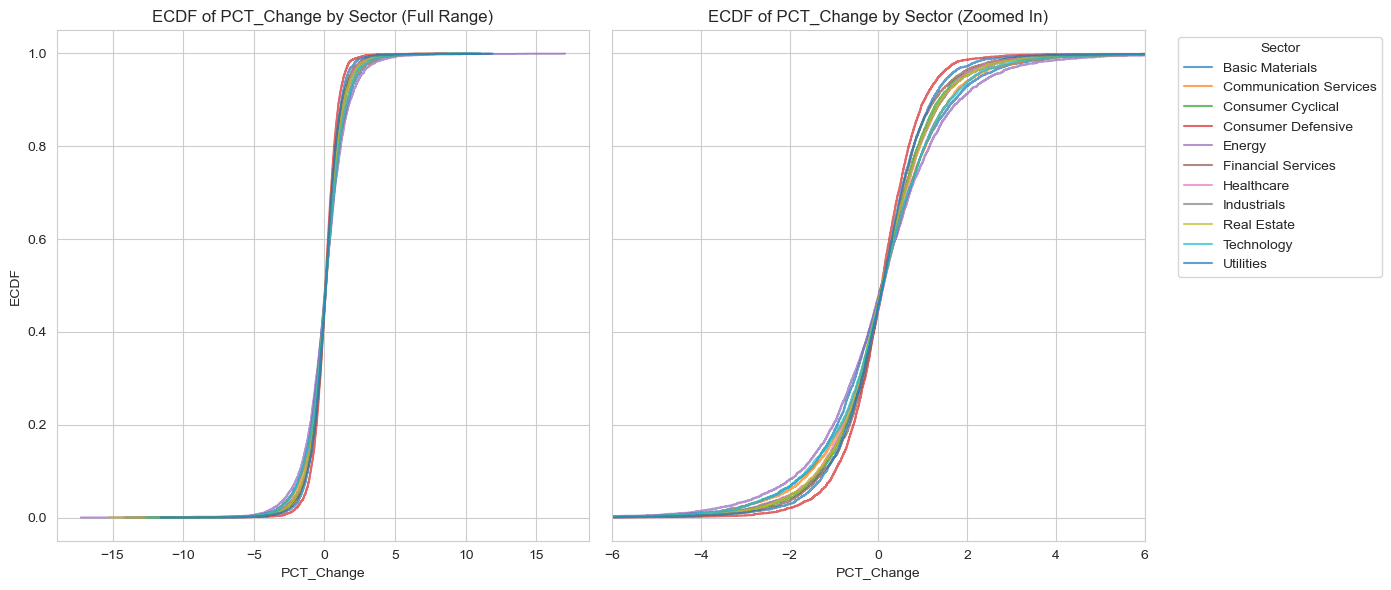

In [32]:
# Read data
df = pd.read_csv('stocks_aggregated.csv')
print(df["Sector"].value_counts())
# Unique categories
categories = df["Sector"].unique()

# normalize to percentage
df['pctChange'] = df['pctChange']*100

# reset variable
categories = df["Sector"].unique()

# set grid
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Plot 1: Full range ECDF ---
for cat in categories:

    # subset and create plot for each sector
    subset = df[df["Sector"] == cat]['pctChange']
    x = np.sort(subset)
    y = np.arange(1, len(x) + 1) / len(x)
    axes[0].step(x, y, where="post", label=cat, alpha=0.7)

axes[0].set_title("ECDF of PCT_Change by Sector (Full Range)")
axes[0].set_xlabel("PCT_Change")
axes[0].set_ylabel("ECDF")
axes[0].grid(True)

# --- Plot 2: Zoomed in ECDF ---
for cat in categories:

    # subset and create plot for each sector
    subset = df[df["Sector"] == cat]['pctChange']
    x = np.sort(subset)
    y = np.arange(1, len(x) + 1) / len(x)
    axes[1].step(x, y, where="post",  label=cat,  alpha=0.7)

axes[1].set_title("ECDF of PCT_Change by Sector (Zoomed In)")
axes[1].set_xlabel("PCT_Change")
axes[1].set_xlim(-6, 6)   # adjust to your preferred zoom level
axes[1].grid(True)

# --- legend ---
axes[1].legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### KDE Plots (Zoomed In/Full Range)

Below is 2 KDE plots with all sectors overlayed. The first KDE shows the full range of the density distributions of the sectors. Due to the high concentration of data, a second KDE showing a zoomed in (changing scope fo graph) view to highlight the unique distributions of each sector.

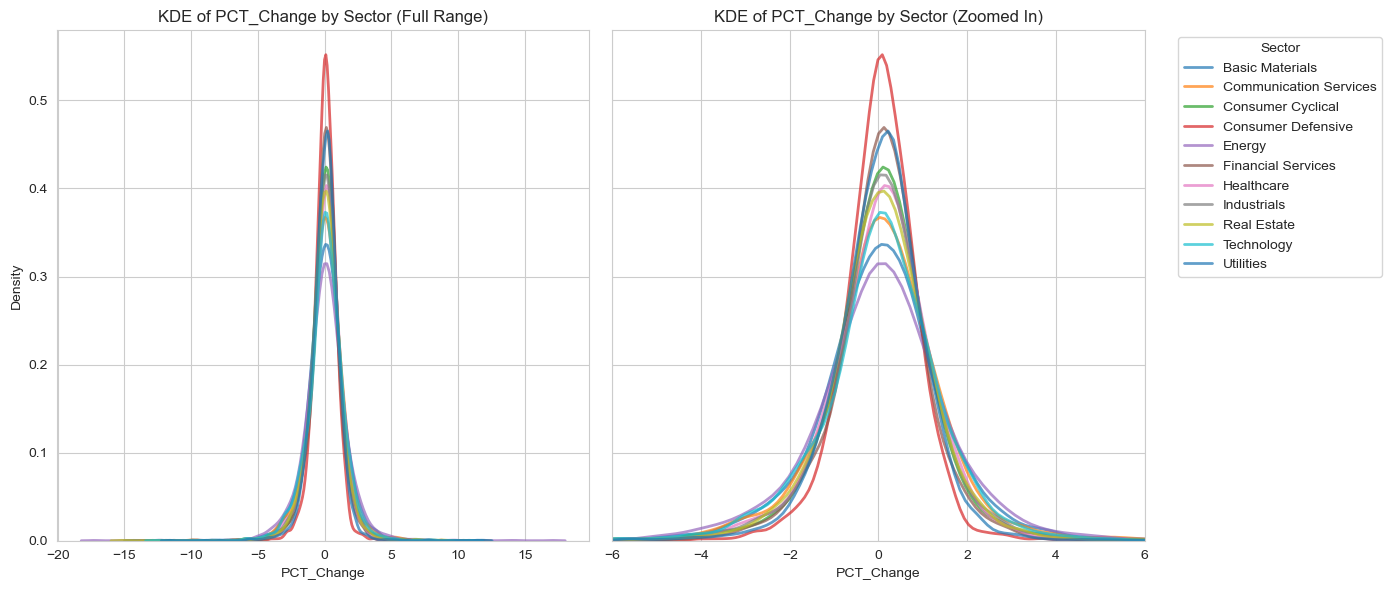

In [33]:
categories = df["Sector"].unique()

# creates grid for plots
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Plot 1: Full range ---
for cat in categories:

    # subset for each sector and plot
    subset = df[df["Sector"] == cat]['pctChange']
    sns.kdeplot(subset, label=cat, fill=False, alpha=0.7, linewidth=2, ax=axes[0])

axes[0].set_title("KDE of PCT_Change by Sector (Full Range)")
axes[0].set_xlabel("PCT_Change")
axes[0].set_ylabel("Density")

# --- Plot 2: Zoomed in ---
for cat in categories:

    # subset for each sector and plot
    subset = df[df["Sector"] == cat]['pctChange']
    sns.kdeplot(subset,  label=cat, fill=False, alpha=0.7, linewidth=2, ax=axes[1])

axes[1].set_title("KDE of PCT_Change by Sector (Zoomed In)")
axes[1].set_xlabel("PCT_Change")
axes[1].set_xlim(-6, 6)   # adjust this range to zoom

# --- Legend ---
axes[1].legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### New Value Generation
This code helps assess whether randomly sampling values from the existing ECDF of each sector can produce accurate predictions. The results from this non-parametric approach will be compared with those from the Markov Model to evaluate the strengths and weaknesses of each method.

Given the large number of observations, random sampling from the ECDF is expected to approximate the true underlying structure of the distribution. From the existing ECDF, new percentage change (PCT_Change) values for each sector will be generated over 1,000 simulated days by randomly sampling from the empirical distribution. These generated values will then be used to calculate the overall value of each sector on a daily basis, modeling how sector values evolve over time.

Both the percentage change and overall sector value will be plotted across the 1,000-day simulation to visualize the behavior of the newly generated data. Tracking the overall change in sector value throughout this period allows us to identify which sectors are projected to become the most and least valuable. The PCT_Change trends also provide insight into sector volatility, highlighting which sectors are likely to experience the greatest growth or decline.

In [34]:
# set seed for reproducibility
np.random.seed(42)

# map to store sector dfs
df_map = {}

# map to store pct_change values for each sector
pct_map = {}

# Creates dictionary with pctChange values of each sector
for cat in categories:

    # filters by sector and maps sector name to sector df
    subset = df[df["Sector"] == cat].reset_index(drop=True)
    df_map[cat] = subset

    # converts each sector's pct change to array and maps values to name of sector
    subset = df[df["Sector"] == cat]['pctChange'].reset_index(drop=True)
    pct_map[cat] = subset.to_numpy()

# loops through and generates new values for each day of each sector and adds to dataframe
for cat in categories:

    new_values = []
    current_vals = pct_map[cat]
    sector_df = df_map[cat]

    # generates new pct_change value for each day
    for i in range(len(pct_map[cat])):

        # Set first day to same value as original data
        if i == 0:
            new_values.append(current_vals[i])
        
        # selects a random PCT_change value from distribution
        else:
            val = np.random.randint(1, len(current_vals))
            new_values.append(current_vals[val])

    # adds new values to dataframe 
    sector_df['Sim_pct_change'] = new_values
    sector_df['Sim_pct_change'] = sector_df['Sim_pct_change'].astype('float64')
    df_map[cat] = sector_df

# calculates the change in daily value of sector for each day of generated values
for cat in categories:

    sector_df = df_map[cat]
    new_values = []

    for i in range(len(sector_df)):

        if i == 0:
            new_values.append(sector_df['Adj Close'].iloc[i])

        # gets previous day's adjusted close value and calculates new value
        else:
            pct_change = sector_df['Sim_pct_change'].iloc[i]
            value = new_values[i-1]
            value = (value * (1 + pct_change/100))
            new_values.append(value)

    sector_df['Sim_adj_close'] = new_values
    sector_df['Sim_adj_close'] = sector_df['Sim_adj_close'].astype('float64')
    df_map[cat] = sector_df


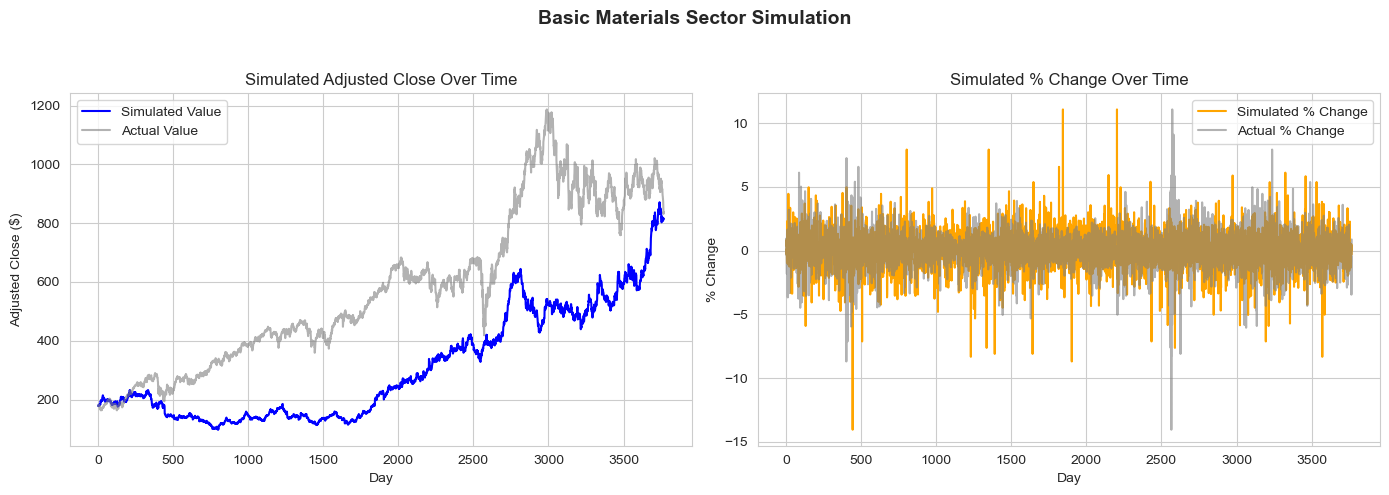

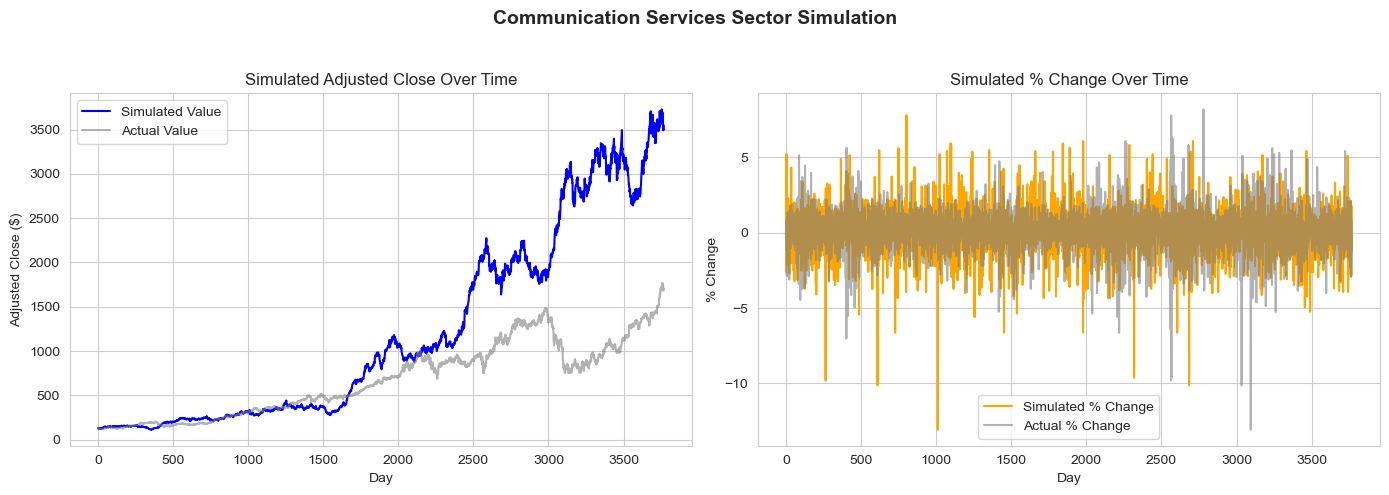

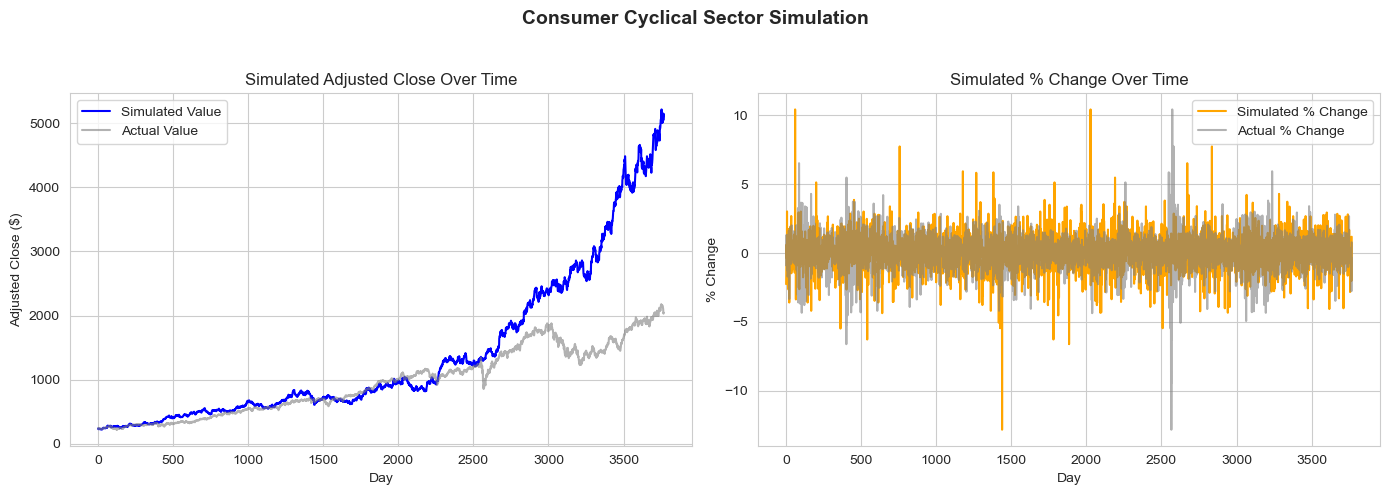

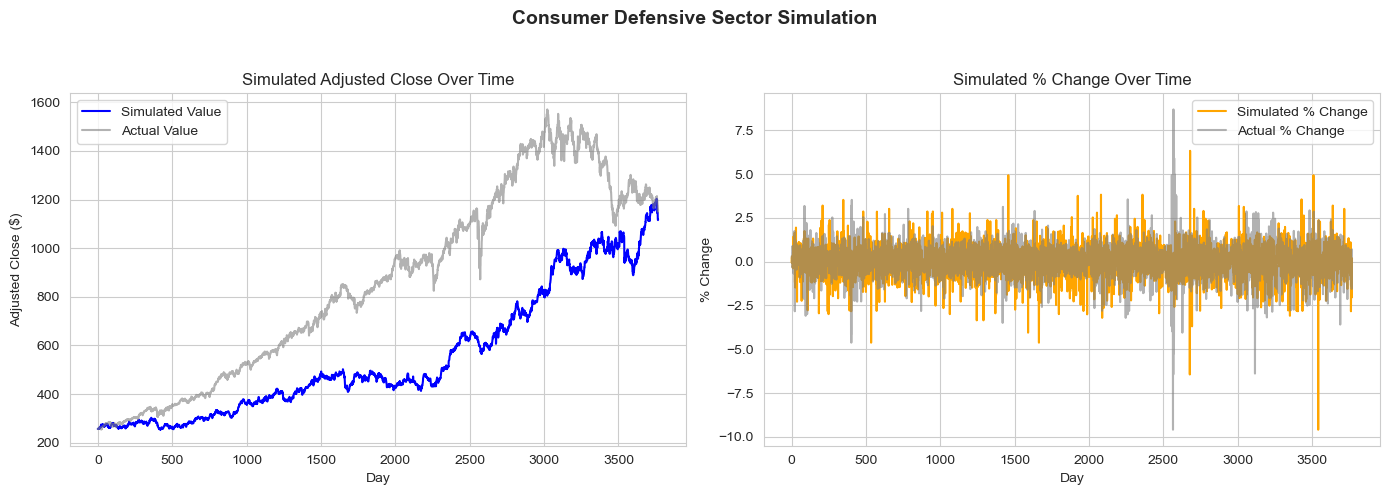

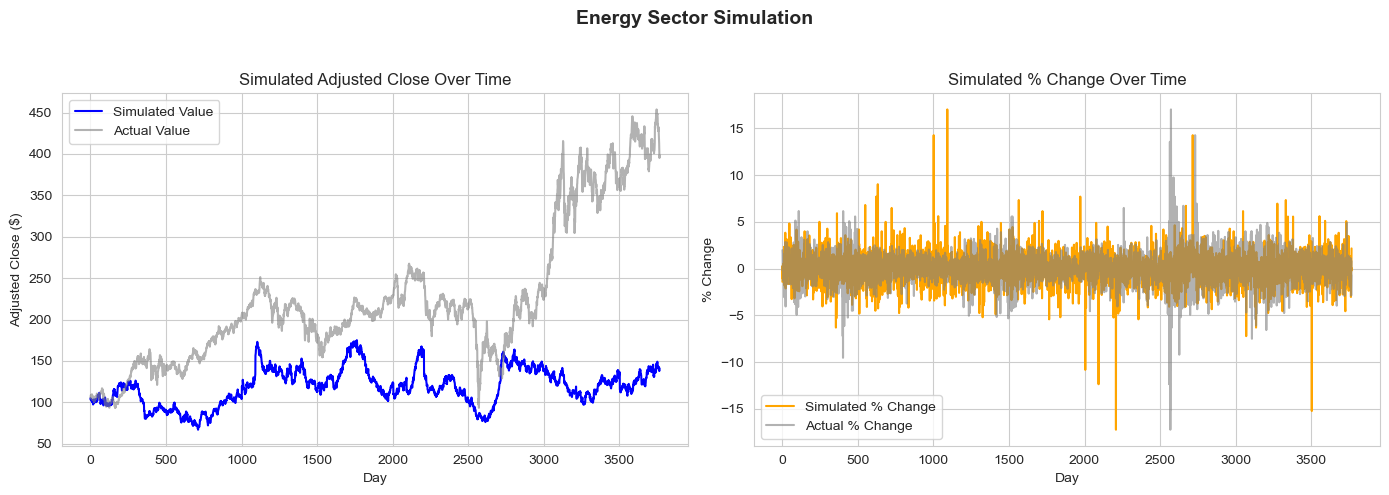

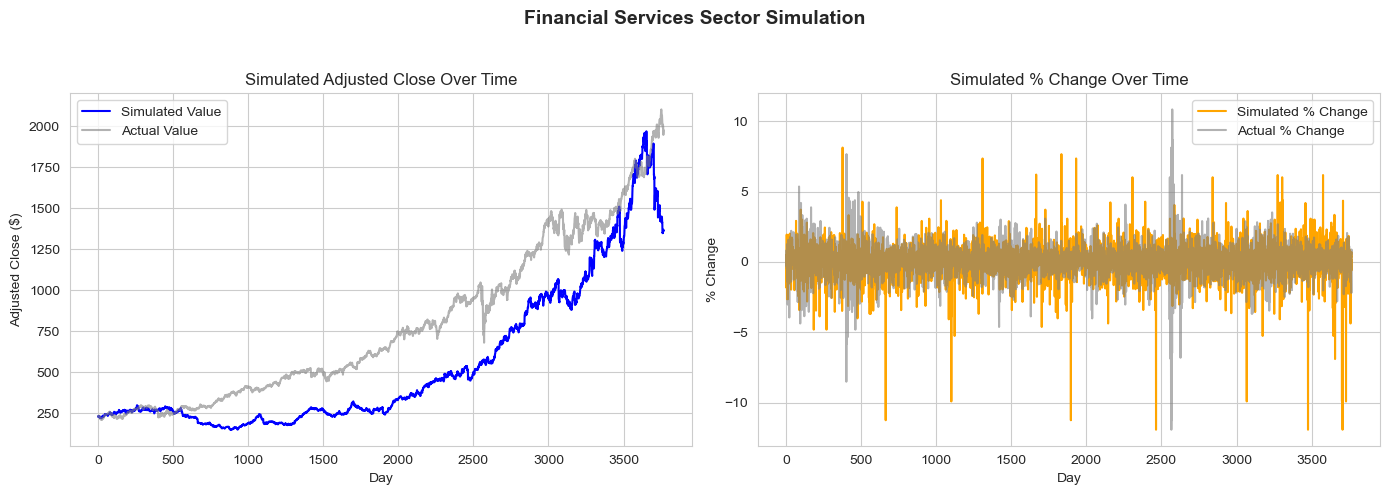

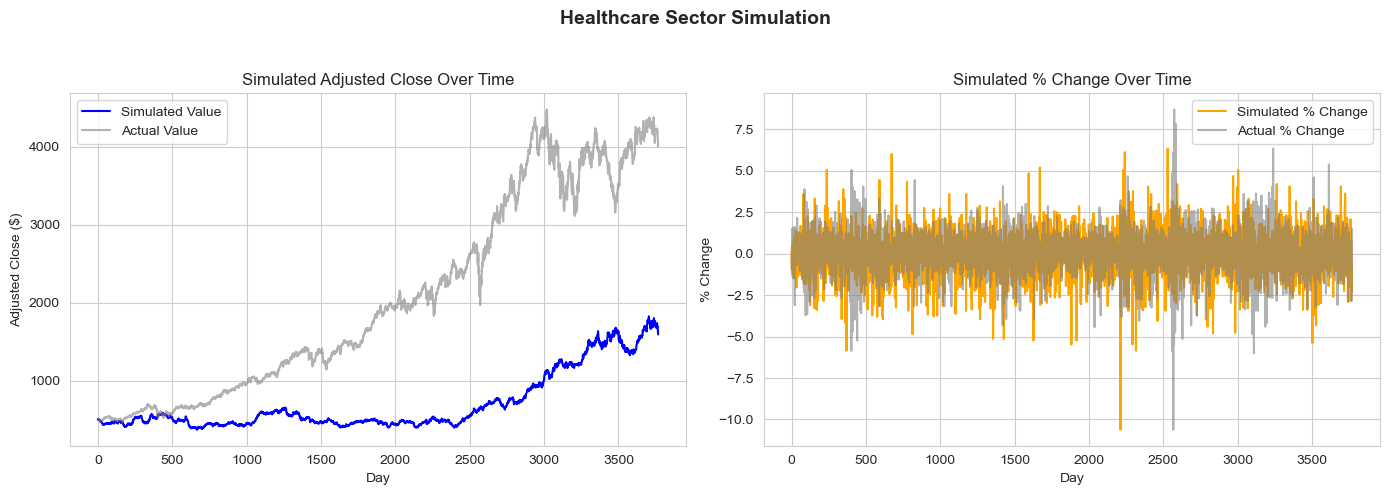

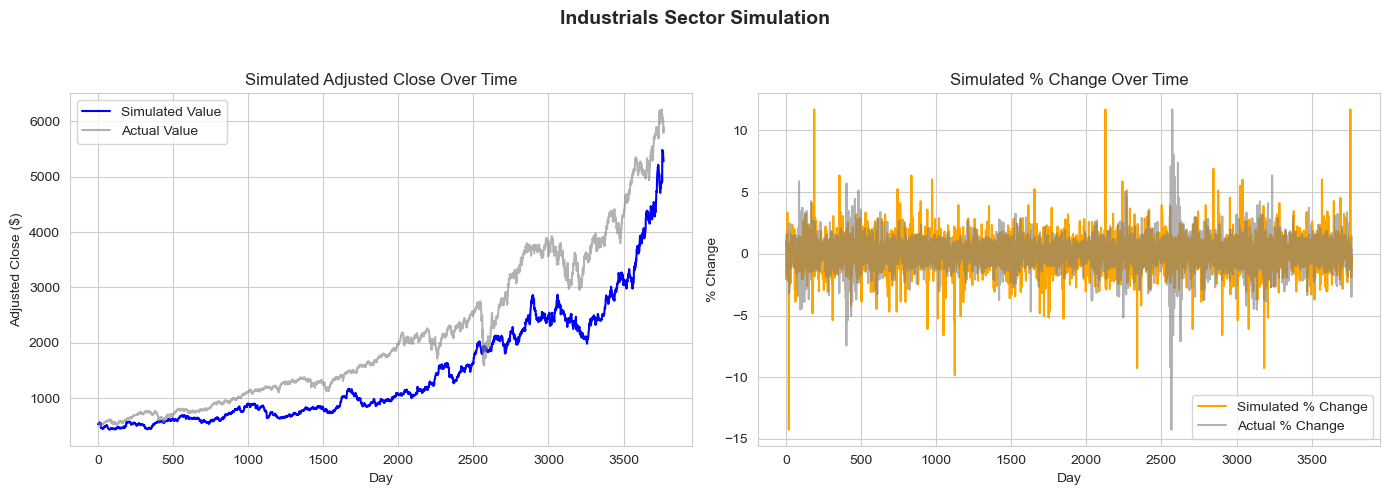

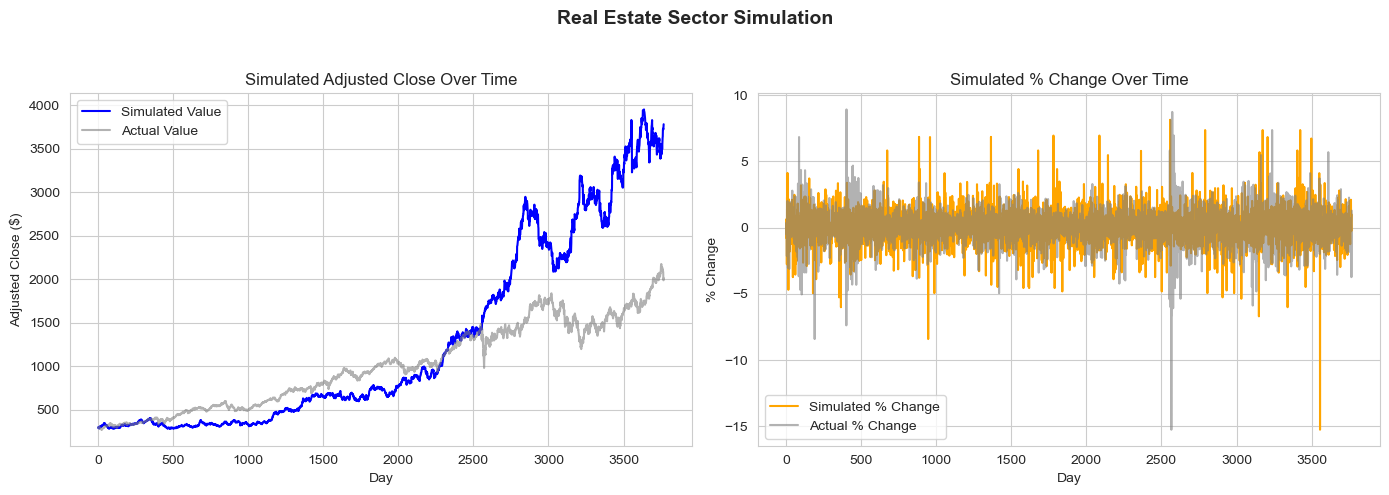

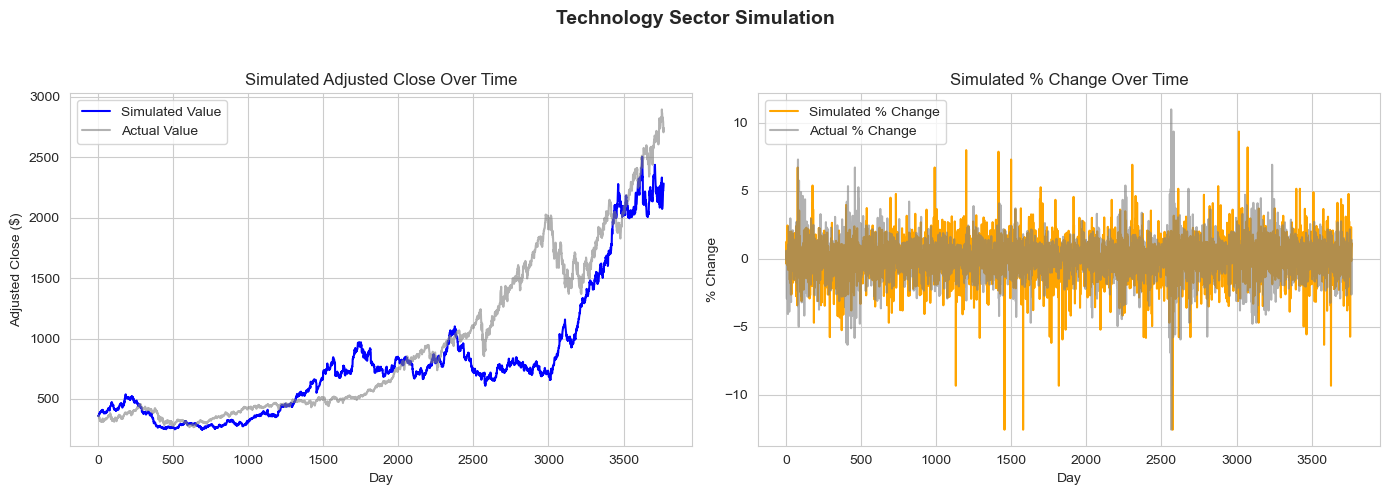

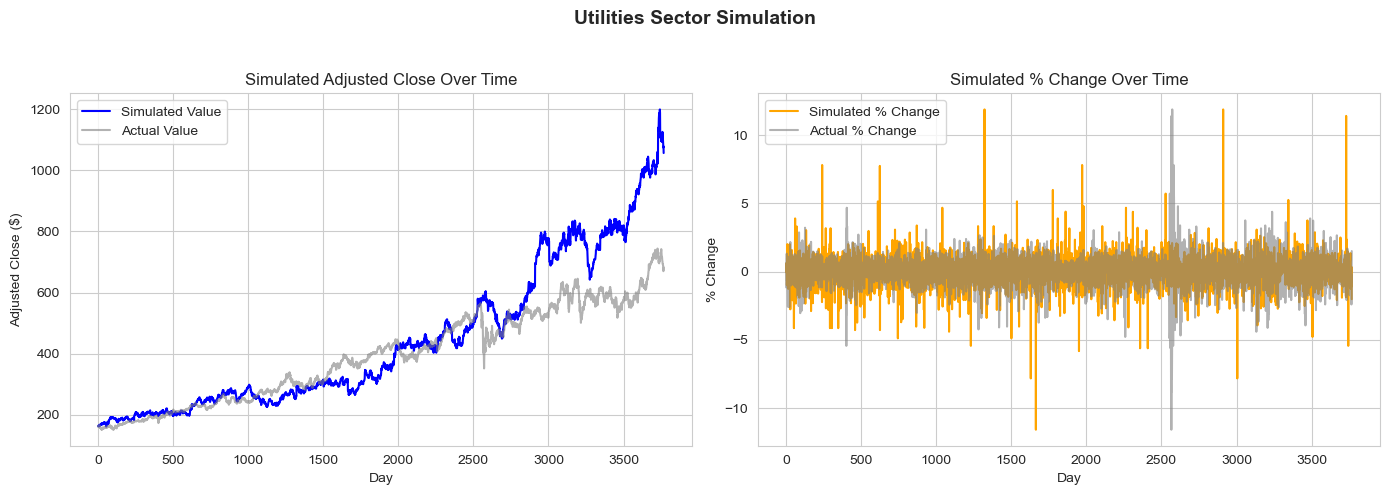

In [35]:
sns.set_style("whitegrid")

for cat in categories:
    sector_df = df_map[cat]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"{cat} Sector Simulation", fontsize=14, fontweight='bold')

    # ---- Plot 1: Simulated Adjusted Close ----
    axes[0].plot(sector_df.index, sector_df["Sim_adj_close"], label="Simulated Value", color='blue')
    axes[0].plot(sector_df.index, sector_df["Adj Close"], label="Actual Value", color='gray', alpha=0.6)
    axes[0].set_title("Simulated Adjusted Close Over Time")
    axes[0].set_xlabel("Day")
    axes[0].set_ylabel("Adjusted Close ($)")
    axes[0].legend()

    # ---- Plot 2: Simulated % Change ----
    axes[1].plot(sector_df.index, sector_df["Sim_pct_change"], label="Simulated % Change", color='orange')
    axes[1].plot(sector_df.index, sector_df["pctChange"], label="Actual % Change", color='gray', alpha=0.6)
    axes[1].set_title("Simulated % Change Over Time")
    axes[1].set_xlabel("Day")
    axes[1].set_ylabel("% Change")
    axes[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

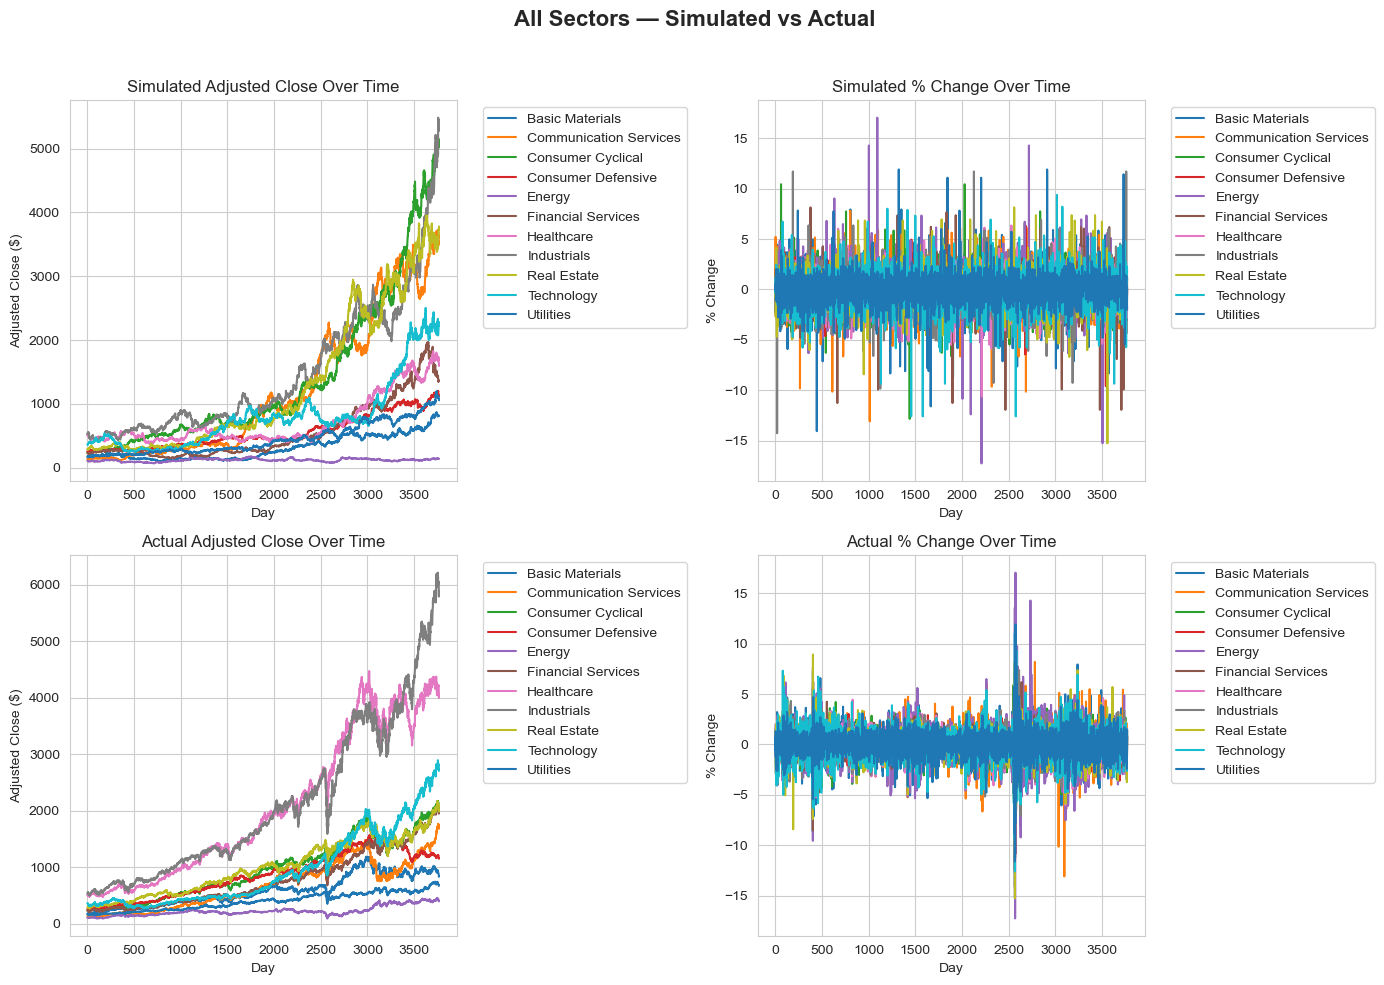

In [36]:
sns.set_style("whitegrid")

# ---- Combined Figure (2x2 Grid) ----
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("All Sectors — Simulated vs Actual", fontsize=16, fontweight='bold')


# ---- Plot 1: Simulated Adj Close overtime ----
for cat in categories:
    sector_df = df_map[cat]
    axes[0, 0].plot(sector_df.index, sector_df["Sim_adj_close"], label=cat)

axes[0, 0].set_title("Simulated Adjusted Close Over Time")
axes[0, 0].set_xlabel("Day")
axes[0, 0].set_ylabel("Adjusted Close ($)")
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# ---- Plot 2: Simulated % Change overtime ----
for cat in categories:
    sector_df = df_map[cat]
    axes[0, 1].plot(sector_df.index, sector_df["Sim_pct_change"], label=cat)

axes[0, 1].set_title("Simulated % Change Over Time")
axes[0, 1].set_xlabel("Day")
axes[0, 1].set_ylabel("% Change")
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')


# ---- Plot 3: Actual Adj close overtime ----
for cat in categories:
    sector_df = df_map[cat]
    axes[1, 0].plot(sector_df.index, sector_df["Adj Close"], label=cat)

axes[1, 0].set_title("Actual Adjusted Close Over Time")
axes[1, 0].set_xlabel("Day")
axes[1, 0].set_ylabel("Adjusted Close ($)")
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# ---- Plot 4: Actual % Change Overtime ----
for cat in categories:
    sector_df = df_map[cat]
    axes[1, 1].plot(sector_df.index, sector_df["pctChange"], label=cat)

axes[1, 1].set_title("Actual % Change Over Time")
axes[1, 1].set_xlabel("Day")
axes[1, 1].set_ylabel("% Change")
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Sector Percentage Change and Value 1,000 Day Prediction

Pending Markov Chain completion